# Create graphiz visualisation

> This module creates the workflow visualisation based on the instances and using the `graphiz` module.

In [18]:
#| default_exp viz

In [19]:
#| hide
from nbdev.showdoc import *

In [20]:
#| export
import graphviz
from fastcore.test import *
import operator # also gets imported with fasthtml.common
from infoflow.classdb import *
from infoflow.creinst import *

## Creating some instances for testing

In [21]:
tools_from_code()
informationitems_from_code()

In [22]:
tools_inst = Tool.get_instances()
items_inst = InformationItem.get_instances()

In [23]:
tools_inst

{'reader': Tool(name='Reader', organization_system=[<OrganizationSystem.TAGS: 'tags'>], phase_quality=PhaseQualityData(collect=<PhaseQuality.GREAT: 'great'>, retrieve=<PhaseQuality.BAD: 'bad'>, consume=<PhaseQuality.GREAT: 'great'>, extract=<PhaseQuality.NA: 'na'>, refine=<PhaseQuality.NA: 'na'>), collect=None, retrieve=None, consume=None, extract=None, refine=None, slug='reader'),
 'recall': Tool(name='Recall', organization_system=[<OrganizationSystem.LINKS: 'links'>], phase_quality=PhaseQualityData(collect=<PhaseQuality.GREAT: 'great'>, retrieve=<PhaseQuality.GREAT: 'great'>, consume=<PhaseQuality.NA: 'na'>, extract=<PhaseQuality.NA: 'na'>, refine=<PhaseQuality.GREAT: 'great'>), collect=None, retrieve=None, consume=None, extract=None, refine=None, slug='recall'),
 'readwise': Tool(name='Readwise', organization_system=[<OrganizationSystem.TAGS: 'tags'>], phase_quality=PhaseQualityData(collect=<PhaseQuality.NA: 'na'>, retrieve=<PhaseQuality.OK: 'ok'>, consume=<PhaseQuality.NA: 'na'>, e

In [24]:
items_inst

{'web_article': InformationItem(name='Web Article', info_type=<InformationType.WEB_ARTICLE: 'web_article'>, method=PhaseMethodData(collect=<Method.MANUAL: 'manual'>, retrieve=None, consume=None, extract=None, refine=None), toolflow=PhaseToolflowData(collect=('reader', 'recall'), retrieve='recall', consume='reader', extract=None, refine=None), slug='web_article'),
 'annotation': InformationItem(name='Annotation', info_type=<InformationType.ANNOTATION: 'annotations&highlights'>, method=PhaseMethodData(collect=<Method.AUTOMATIC: 'automatic'>, retrieve=None, consume=None, extract=None, refine=None), toolflow=PhaseToolflowData(collect=None, retrieve=None, consume=None, extract='readwise', refine=('recall', 'obsidian')), slug='annotation'),
 'note': InformationItem(name='Note', info_type=<InformationType.NOTE: 'note'>, method=PhaseMethodData(collect=<Method.MANUAL: 'manual'>, retrieve=None, consume=None, extract=None, refine=None), toolflow=PhaseToolflowData(collect=None, retrieve='obsidian'

In [25]:
test_eq(len(items_inst), 8)
test(tools_inst, "reader", operator.contains)

## Helper functions

The function `get_items_for_tool` filters all the instances of the class InformationItem based on which information items can be processed by the given tool.

In [26]:
#| export
def get_info_items_for_tool(tool_name: str, info_items: dict[InformationItem]) -> dict[InformationItem]:
    """Filters all the instances of the class InformationItem based on which information items can be processed by the given tool."""
    if isinstance(info_items, dict): info_items = info_items.values()
    phases = ['collect', 'retrieve', 'consume', 'extract', 'refine']
    tool_name = tool_name.lower()
    
    res = {}
    for i in info_items:
        tf = getattr(i, 'toolflow', None)
        if tf is None: continue
        for ph in phases:
            ts = getattr(tf, ph, None)
            if ts is None: continue
            if isinstance(ts, (list, tuple)):
                if tool_name in ts: res[i.name] = i; break
            elif ts == tool_name:
                res[i.name] = i; break
    
    return res

Test the `get_info_items_for_tool` function.

In [27]:
get_info_items_for_tool('reader', items_inst)

{'Web Article': InformationItem(name='Web Article', info_type=<InformationType.WEB_ARTICLE: 'web_article'>, method=PhaseMethodData(collect=<Method.MANUAL: 'manual'>, retrieve=None, consume=None, extract=None, refine=None), toolflow=PhaseToolflowData(collect=('reader', 'recall'), retrieve='recall', consume='reader', extract=None, refine=None), slug='web_article')}

## Graphiz visualisation

The function to create the workflow visualisation for the given `info_items` and `tools`.
This is done in two steps. First we use the function `create_workflow_viz` that functions as a wrapper around the `build_graphiz_from_instances` function. 

The `create_workflow_viz` has two tasks:

- It makes calling the `build_graphiz_from_instances` function easier by assuming we want to use all instances from the `Tool` and `InformationItem` classes. If we want to use a single instance, we can pass a single instance of `Tool` or `InformationItem`. If we want several, but not all, instances of `Tool` or `InformationItem`, we can pass a dict of instances.
- It adds the option to filter the graph to be created on a single `Tool`-name. If the parameter `tool_filter` is used, the function calls the `get_info_items_for_tool` function and filters the needed `InformationItem` instances based on that tool. This way only those parts of the graph will be drawn that we want to see.

In [28]:
#| export
# New function based on updated dataclasses
def build_graphiz_from_intances(info_items, tools) -> graphviz.graphs.Digraph:
    """Create a graphviz visualisation using the updated dataclasses for InformationItem and Tool.
    Produces the same layout as build_graphiz_from_instances.
    """
    if isinstance(info_items, dict): info_items = list(info_items.values())
    elif not isinstance(info_items, list): info_items = [info_items]
    if isinstance(tools, dict): tools = list(tools.values())

    dot = graphviz.Digraph(comment='PKM Workflow')
    dot.attr(rankdir='TB')

    phases = ['collect', 'retrieve', 'consume', 'extract', 'refine']
    all_nodes = set()
    edges = {}

    quality_colors = {PhaseQuality.GREAT: 'lightgreen', PhaseQuality.OK: 'lightblue', PhaseQuality.BAD: 'orange', PhaseQuality.NA: 'lightgray'}

    # Create tool nodes per phase
    for phase in phases:
        with dot.subgraph() as s:
            s.attr(rank='same')
            for info_item in info_items:
                tool_entry = getattr(getattr(info_item, 'toolflow', None), phase, None)
                if tool_entry is None: continue
                tools_in_phase = tool_entry if isinstance(tool_entry, (tuple)) else (tool_entry,)
                for tool_slug in tools_in_phase:
                    if tool_slug is None: continue
                    node_id = f"{tool_slug}_{phase}"
                    if node_id in all_nodes: continue
                    tool = next((t for t in tools if getattr(t, 'slug', None) == tool_slug), None)
                    q = getattr(getattr(tool, 'phase_quality', None), phase, PhaseQuality.NA) if tool else PhaseQuality.NA
                    color = quality_colors.get(q, 'white')
                    s.node(node_id, f"{tool_slug}\n({phase})", shape='hexagon', fillcolor=color, style='filled')
                    all_nodes.add(node_id)

    # Create source nodes for each InformationItem type (label with item.name, id by info_type)
    with dot.subgraph() as s:
        s.attr(rank='same')
        for info_item in info_items:
            it = getattr(info_item, 'info_type', None)
            val = it.value if hasattr(it, 'value') else str(it)
            source_id = f"source_{val}"
            s.node(source_id, getattr(info_item, 'name', (val or '').replace('_', ' ').title()), shape='box')

    # Connect edges along the flow
    for info_item in info_items:
        it = getattr(info_item, 'info_type', None)
        val = it.value if hasattr(it, 'value') else str(it)
        source_id = f"source_{val}"
        prev_nodes = [source_id]
        for phase in phases:
            tool_entry = getattr(getattr(info_item, 'toolflow', None), phase, None)
            if tool_entry is None: continue
            curr_nodes = []
            tools_in_phase = tool_entry if isinstance(tool_entry, (list, tuple)) else (tool_entry,)
            for tool_name in tools_in_phase:
                if tool_name is None: continue
                node_id = f"{str(tool_name).lower()}_{phase}"
                curr_nodes.append(node_id)
                for prev in prev_nodes:
                    key = (prev, node_id)
                    if key in edges: continue
                    dot.edge(prev, node_id)
                    edges[key] = True
            if curr_nodes: prev_nodes = curr_nodes

    return dot

In [29]:
#| export
def create_workflow_viz(items: None | InformationItem | dict[str, InformationItem] = None,
                        tools: None | Tool | dict[str, Tool] =None,
                        tool_filter: None | str = None) -> graphviz.graphs.Digraph:
    """Create workflow visualization with flexible filtering options."""
    # Default to all items and tools if none specified
    if items is None: items = InformationItem.get_instances()
    if tools is None: tools = Tool.get_instances()
    
    # Filter by tool if specified
    if tool_filter:
        items = get_info_items_for_tool(tool_filter, items)
    
    return build_graphiz_from_intances(items, tools)

An example for creating the actual visualisation for the given `info_items` and `tools`.

In [30]:
viz = create_workflow_viz(items_inst, tools_inst)
type(viz)

graphviz.graphs.Digraph

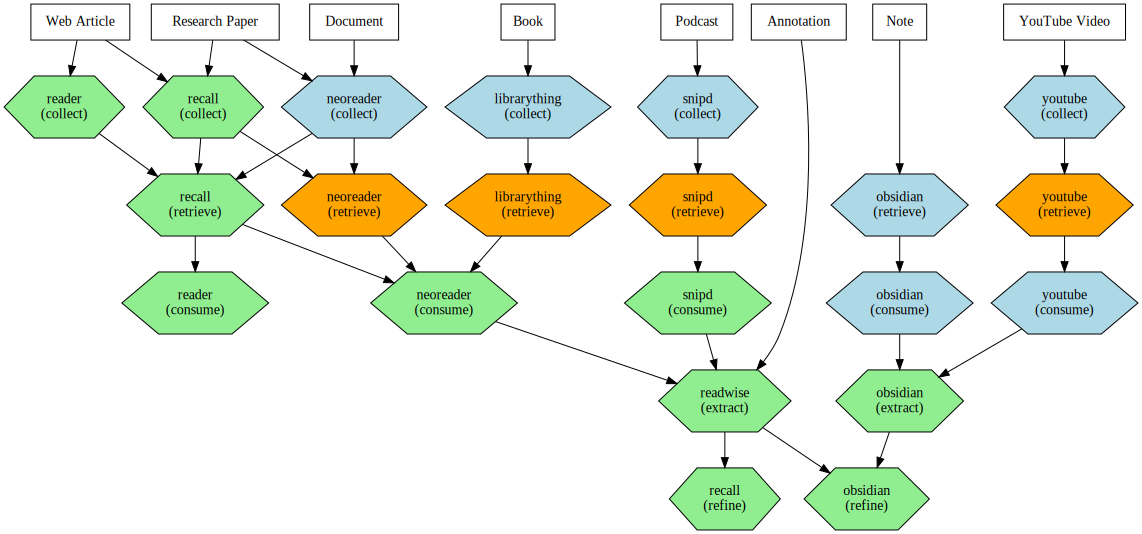

In [31]:
viz

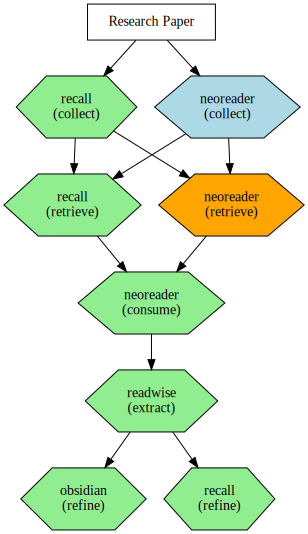

In [32]:
viz_document = create_workflow_viz(items_inst['research_paper'])
viz_document

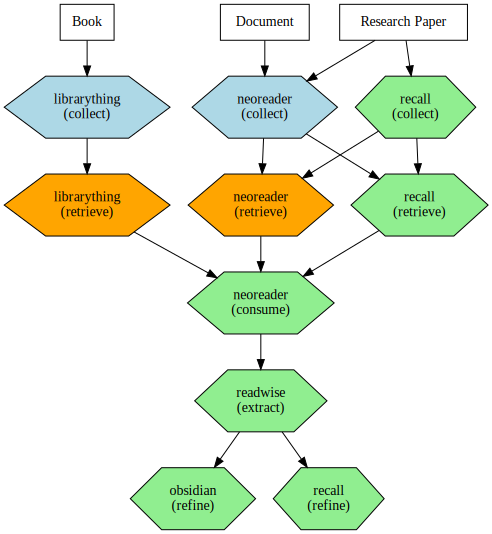

In [33]:
viz_tool = create_workflow_viz(tool_filter='neoreader')
viz_tool

To get the `SVG` output, you can use the `_repr_image_svg_xml` method of the `Digraph` object. Below is an example showing the first 200 characters.

In [34]:
viz._repr_image_svg_xml()[:200]

'<?xml version="1.0" encoding="UTF-8" standalone="no"?>\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"\n "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">\n<!-- Generated by graphviz version 2.43.0 (0)'

In [35]:
#| hide
import nbdev; nbdev.nbdev_export()